# Validation and Model Selection

Credits: Forked from [PyCon 2015 Scikit-learn Tutorial](https://github.com/jakevdp/sklearn_pycon2015) by Jake VanderPlas

In this section, we'll look at *model evaluation* and the tuning of *hyperparameters*, which are parameters that define the model.

在本节中，我们将研究*模型评估*和*超参数*的调整，超参数是定义模型的参数。

In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()

## Validating Models
## 验证模型

One of the most important pieces of machine learning is **model validation**: that is, checking how well your model fits a given dataset. But there are some pitfalls you need to watch out for.
机器学习中最重要的部分之一是 **模型验证**：即检查您的模型与给定数据集的拟合程度。但是您需要注意一些陷阱。

Consider the digits example we've been looking at previously. How might we check how well our model fits the data?

考虑我们之前看过的数字示例。我们如何检查我们的模型与数据的拟合程度？

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

Let's fit a K-neighbors classifier

In [3]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Now we'll use this classifier to *predict* labels for the data

现在我们将使用此分类器来 *预测* 数据的标签

In [4]:
y_pred = knn.predict(X)

Finally, we can check how well our prediction did:

In [5]:
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


It seems we have a perfect classifier!

**Question: what's wrong with this?**

## Validation Sets
## 验证集

Above we made the mistake of testing our data on the same set of data that was used for training. **This is not generally a good idea**. If we optimize our estimator this way, we will tend to **over-fit** the data: that is, we learn the noise.
上面我们犯了一个错误，即在用于训练的同一数据集上测试我们的数据。**这通常不是一个好主意**。如果我们以这种方式优化我们的估计器，我们将倾向于 **过拟合** 数据：也就是说，我们学习了噪声。

A better way to test a model is to use a hold-out set which doesn't enter the training. We've seen this before using scikit-learn's train/test split utility:

测试模型的更好方法是使用不进入训练的保留集。我们之前在使用 scikit-learn 的训练/测试拆分实用程序时已经看到过这一点：

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((1347, 64), (450, 64))

Now we train on the training data, and validate on the test data:

In [8]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

443 / 450 correct


This gives us a more reliable estimate of how our model is doing.

这让我们能够更可靠地评估模型的运行情况。

The metric we're using here, comparing the number of matches to the total number of samples, is known as the **accuracy score**, and can be computed using the following routine:

我们在这里使用的指标是匹配数与样本总数的比较，称为**准确度得分**，可以使用以下程序计算：

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9844444444444445

This can also be computed directly from the ``model.score`` method:

这也可以直接从“model.score”方法计算：

In [10]:
knn.score(X_test, y_test)

0.9844444444444445

Using this, we can ask how this changes as we change the model parameters, in this case the number of neighbors:

使用这个，我们可以询问当我们更改模型参数时，这种情况会如何变化，在这种情况下是邻居的数量：

In [11]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

1 0.9844444444444445
5 0.9866666666666667
10 0.9755555555555555
20 0.9622222222222222
30 0.9511111111111111


We see that in this case, a small number of neighbors seems to be the best option.

我们看到，在这种情况下，少数量的邻居似乎是最好的选择。

## Cross-Validation
## 交叉验证

One problem with validation sets is that you "lose" some of the data. Above, we've only used 3/4 of the data for the training, and used 1/4 for the validation. Another option is to use **2-fold cross-validation**, where we split the sample in half and perform the validation twice:

验证集的一个问题是您会“丢失”一些数据。上面，我们只使用了 3/4 的数据进行训练，并使用了 1/4 进行验证。另一种选择是使用 **2 折交叉验证**，我们将样本分成两半并执行两次验证：

In [12]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((898, 64), (899, 64))

In [13]:
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.9832962138084632
0.982202447163515


Thus a two-fold cross-validation gives us two estimates of the score for that parameter.

因此，双重交叉验证可以让我们得到该参数得分的两个估计值。

Because this is a bit of a pain to do by hand, scikit-learn has a utility routine to help:

由于手动操作比较麻烦，scikit-learn 提供了一个实用程序来帮助解决：

In [15]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=10)
cv.mean()

np.float64(0.9749627560521414)

### K-fold Cross-Validation

Here we've used 2-fold cross-validation. This is just one specialization of $K$-fold cross-validation, where we split the data into $K$ chunks and perform $K$ fits, where each chunk gets a turn as the validation set.

这里我们使用了 2 折交叉验证。这只是 $K$ 折交叉验证的一种特殊形式，我们将数据分成 $K$ 个块，并进行 $K$ 次拟合，每个块作为验证集。

We can do this by changing the ``cv`` parameter above. Let's do 10-fold cross-validation:

我们可以通过更改上面的 ``cv`` 参数来实现这一点。让我们进行 10 折交叉验证：

In [16]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=10)

array([0.93333333, 0.99444444, 0.97222222, 0.97222222, 0.96666667,
       0.98333333, 0.99444444, 0.98882682, 0.97765363, 0.96648045])

This gives us an even better idea of how well our model is doing.

这让我们更好地了解我们的模型的运行情况。

## Overfitting, Underfitting and Model Selection

## 过拟合、欠拟合和模型选择

Now that we've gone over the basics of validation, and cross-validation, it's time to go into even more depth regarding model selection.
既然我们已经介绍了验证和交叉验证的基础知识，现在是时候更深入地探讨模型选择了。

The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.  Selecting the optimal model
for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.
与验证和交叉验证相关的问题是机器学习实践中最重要的方面。为您的数据选择最佳模型至关重要，这是机器学习从业者通常不了解的问题的一部分。

Of core importance is the following question:
核心重要性是以下问题：

**If our estimator is underperforming, how should we move forward?**
**如果我们的估计器表现不佳，我们应该如何前进？**

- Use simpler or more complicated model?
使用更简单还是更复杂的模型？
- Add more features to each observed data point?
为每个观察到的数据点添加更多特征？
- Add more training samples?
添加更多训练样本？

The answer is often counter-intuitive.  In particular, **Sometimes using a
more complicated model will give _worse_ results.**  Also, **Sometimes adding
training data will not improve your results.**  The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

答案通常是违反直觉的。特别是，**有时使用更复杂的模型会产生 _更差_ 的结果。** 此外，**有时添加训练数据不会改善您的结果。** 确定哪些步骤可以改善您的模型的能力是将成功的机器学习从业者与不成功的机器学习从业者区分开来的原因。

### Illustration of the Bias-Variance Tradeoff  偏差-方差权衡说明

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

本节我们将处理一个简单的一维回归问题。这将有助于我们
轻松地可视化数据和模型，并且结果可以轻松推广到高维数据集。我们将探索一个简单的**线性回归**问题。
这可以在 scikit-learn 中使用 `sklearn.linear_model` 模块完成。

We'll create a simple nonlinear function that we'd like to fit

我们将创建一个简单的非线性函数，并对其进行拟合

In [17]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

现在让我们创建这个数据集的实现：

In [18]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

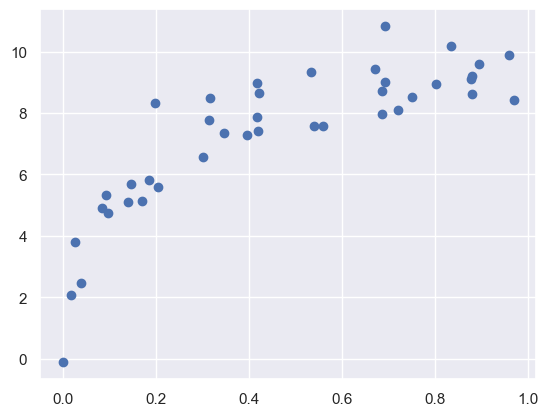

In [19]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

Now say we want to perform a regression on this data.  Let's use the built-in linear regression function to compute a fit:

现在假设我们想对这些数据进行回归。让我们使用内置的线性回归函数来计算拟合：

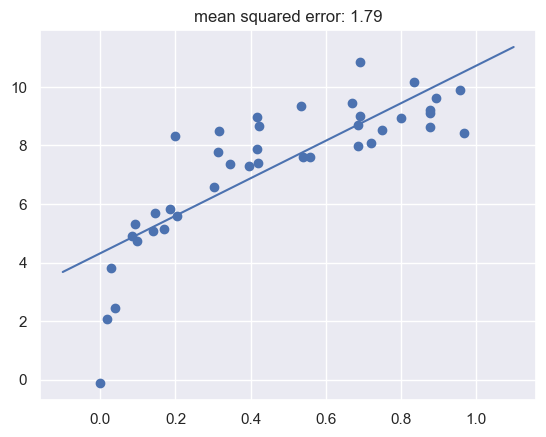

In [20]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model is **biased**, or that it **under-fits** the data.

我们已经用直线拟合了数据，但显然这个模型不是一个好的选择。我们说这个模型**有偏差**，或者说它**欠拟合**了数据。

Let's try to improve this by creating a more complicated model.  We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs. Scikit-learn makes this easy with the ``PolynomialFeatures`` preprocessor, which can be pipelined with a linear regression.

让我们尝试创建一个更复杂的模型来改进它。我们可以通过增加自由度，并对输入进行多项式回归来实现。Scikit-learn 的“PolynomialFeatures”预处理器可以轻松实现这一点，它可以与线性回归进行流水线化。

Let's make a convenience routine to do this:

让我们编写一个便捷的例程来执行此操作：

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now we'll use this to fit a quadratic curve to the data.

现在我们将使用它来拟合数据的二次曲线。

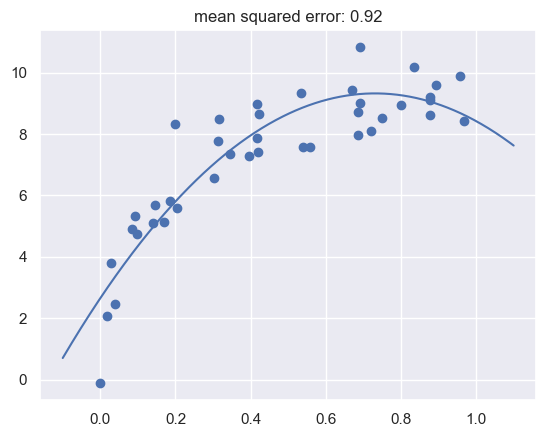

In [22]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

这降低了均方误差，并使拟合度更好。如果我们使用更高次的多项式会发生什么？

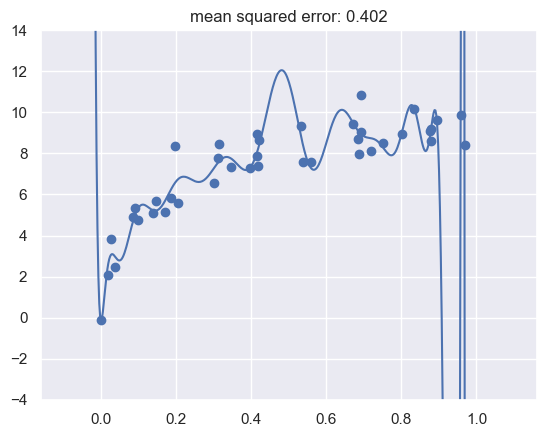

In [23]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

当我们将阶数增加到这个程度时，很明显，最终的拟合结果不再反映真实的底层分布，而是对训练数据中的噪声更加敏感。因此，我们称之为**高方差模型**，并称其**过拟合**了数据。

Just for fun, let's use IPython's interact capability (only in IPython 2.0+) to explore this interactively:

为了好玩，让我们使用 IPython 的交互功能（仅在 IPython 2.0+ 中）来交互式地探索这一点：

In [24]:
from ipywidgets import interact

def plot_fit(degree=1, Npts=50):
    X, y = make_data(Npts, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[:, None]
    
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y_test = model.predict(X_test)

    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test)
    plt.ylim(-4, 14)
    plt.title("mean squared error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))
    
interact(plot_fit, degree=[1, 30], Npts=[2, 100]);

interactive(children=(Dropdown(description='degree', options=(1, 30), value=1), Dropdown(description='Npts', o…

### Detecting Over-fitting with Validation Curves 使用验证曲线检测过拟合

Clearly, computing the error on the training data is not enough (we saw this previously). As above, we can use **cross-validation** to get a better handle on how the model fit is working.

显然，仅仅计算训练数据的误差是不够的（我们之前已经见过）。如上所述，我们可以使用**交叉验证**来更好地了解模型拟合的效果。

Let's do this here, again using the ``validation_curve`` utility. To make things more clear, we'll use a slightly larger dataset:

我们在这里再次使用“validation_curve”实用程序来执行此操作。为了更清晰地说明，我们将使用一个稍大的数据集：

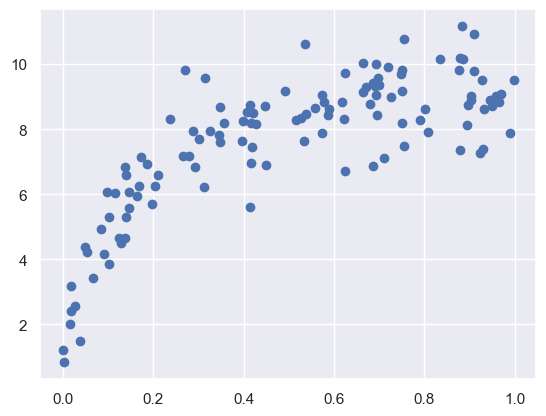

In [62]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [63]:
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer

def rms_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rms_scorer = make_scorer(rms_error, greater_is_better=False)

degree = np.arange(0, 18)
val_train, val_test = validation_curve(
    PolynomialRegression(), X, y,
    param_name='polynomialfeatures__degree',
    param_range=degree,
    cv=7,
    scoring=rms_scorer
)

Now let's plot the validation curves:

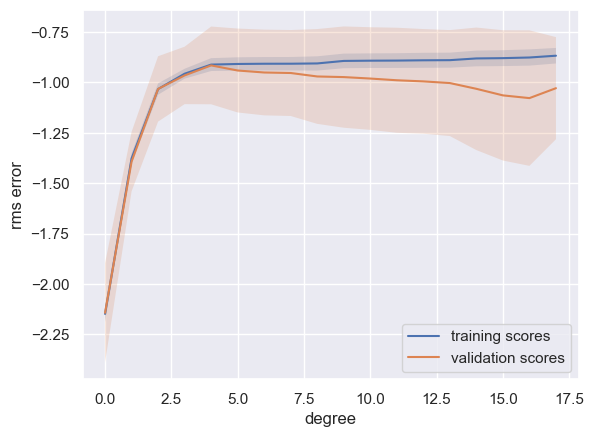

In [88]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend()

Notice the trend here, which is common for this type of plot.
注意此处的趋势，这对于此类图很常见。

1. For a small model complexity, the training error and validation error are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

对于较小的模型复杂度，训练误差和验证误差非常相似。这表明模型 **欠拟合** 数据：它没有足够的复杂度来表示数据。另一种说法是，这是一个 **高偏差** 模型。

2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

随着模型复杂度的增加，训练和验证分数出现分歧。这表明模型 **过拟合** 数据：它具有很大的灵活性，以至于它拟合了噪声而不是潜在的趋势。另一种说法是，这是一个 **高方差** 模型。

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

请注意，训练分数（几乎）总是随着模型复杂度的增加而提高。这是因为更复杂的模型可以更好地拟合噪声，因此模型会得到改善。验证数据通常有一个最佳点，这里大约有 5 项。

Here's our best-fit model according to the cross-validation:

根据交叉验证，这是我们的最佳拟合模型：

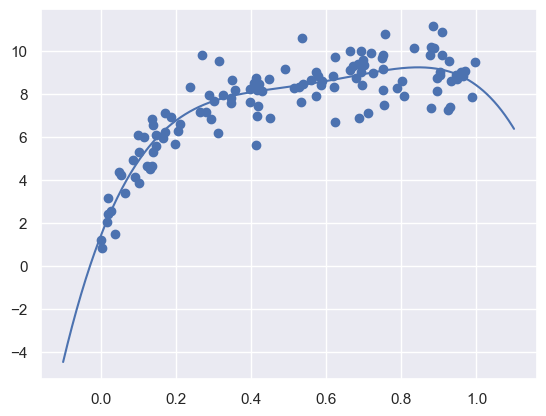

In [81]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

### Detecting Data Sufficiency with Learning Curves 使用学习曲线检测数据充分性

As you might guess, the exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.  Here we'll illustrate the use of *learning curves*, which display this property.

正如你可能猜到的，偏差和方差之间权衡的确切转折点高度依赖于所使用的训练点数量。这里我们将演示如何运用体现这一特性的*学习曲线*。

The idea is to plot the mean-squared-error for the training and test set as a function of *Number of Training Points*

其思路是将训练集和测试集的均方误差绘制为*训练点数量*的函数。

In [93]:
from sklearn.model_selection import learning_curve

# def plot_with_err(x, data, **kwargs):
#     mu, std = data.mean(1), data.std(1)
#     lines = plt.plot(x, mu, '-', **kwargs)
#     plt.fill_between(x, mu - std, mu + std, edgecolor='none',
#                      facecolor=lines[0].get_color(), alpha=0.2)

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, train_scores, test_scores = learning_curve(
        PolynomialRegression(degree),
        X, y,
        train_sizes=train_sizes,
        cv=5,
        scoring=rms_scorer
    )
    plot_with_err(N_train, train_scores, label='training scores')
    plot_with_err(N_train, test_scores, label='validation scores')

    plt.xlabel('Training Set Size')
    plt.ylabel('rms error')
    plt.legend()

Let's see what the learning curves look like for a linear model:

让我们看看线性模型的学习曲线是什么样的：

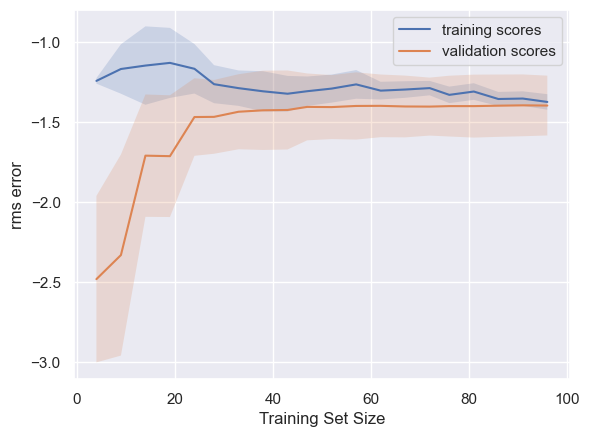

In [94]:
plot_learning_curve(1)

This shows a typical learning curve: for very few training points, there is a large separation between the training and test error, which indicates **over-fitting**.  Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential **under-fitting**.
这显示了一条典型的学习曲线：对于很少的训练点，训练误差和测试误差之间存在很大的差距，这表明 **过拟合**。给定相同的模型，对于大量的训练点，训练和测试误差会收敛，这表明可能存在 **欠拟合**。

As you add more data points, the training error will never increase, and the testing error will never decrease (why do you think this is?)
随着您添加更多数据点，训练误差永远不会增加，测试误差也永远不会减少（您认为这是为什么？）

It is easy to see that, in this plot, if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will *never* get you there.  For $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

很容易看出，在此图中，如果您想将 MSE 降低到标称值 1.0（这是我们在构建数据时放入的散布幅度），那么添加更多样本将 *永远* 无法实现。对于 $d=1$，两条曲线已经收敛并且不能再降低。那么对于更大的 $d$ 值呢？

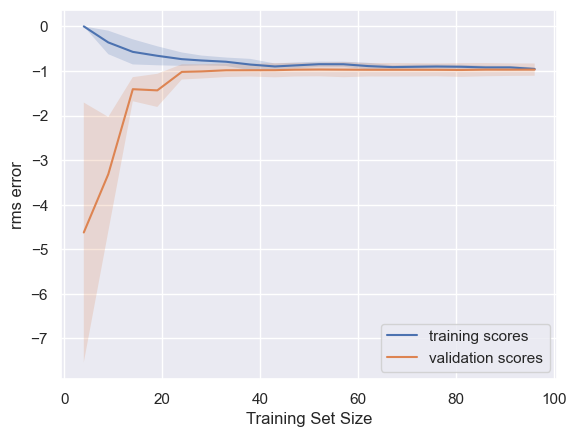

In [95]:
plot_learning_curve(3)

Here we see that by adding more model complexity, we've managed to lower the level of convergence to an rms error of 1.0!

我们看到，通过增加模型复杂度，我们成功地将收敛水平降低到了均方根误差 1.0！

What if we get even more complex?

如果我们的模型更加复杂呢？

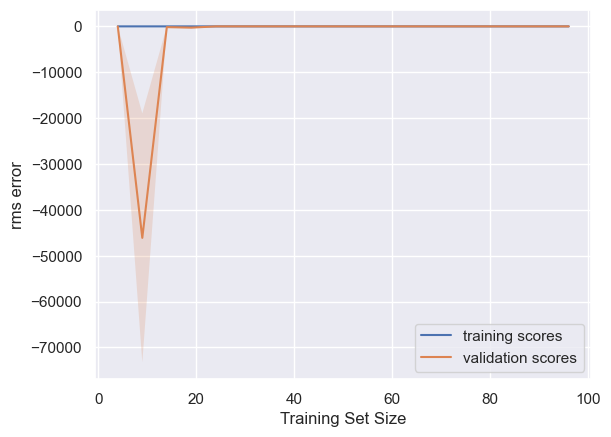

In [96]:
plot_learning_curve(10)

For an even more complex model, we still converge, but the convergence only happens for *large* amounts of training data.

对于更复杂的模型，我们仍然会收敛，但收敛只有在*大量*训练数据的情况下才会发生。

So we see the following: 因此，我们看到：

- you can **cause the lines to converge** by adding more points or by simplifying the model.

你可以通过添加更多点或简化模型来**使线条收敛**。

- you can **bring the convergence error down** only by increasing the complexity of the model.

你只能通过增加模型的复杂度来**降低收敛误差**。

Thus these curves can give you hints about how you might improve a sub-optimal model. If the curves are already close together, you need more model complexity. If the curves are far apart, you might also improve the model by adding more data.

因此，这些曲线可以为你提供一些关于如何改进次优模型的提示。如果曲线已经很接近，则需要提高模型复杂度。如果曲线相距较远，你也可以通过添加更多数据来改进模型。

To make this more concrete, imagine some telescope data in which the results are not robust enough.  You must think about whether to spend your valuable telescope time observing *more objects* to get a larger training set, or *more attributes of each object* in order to improve the model.  The answer to this question has real consequences, and can be addressed using these metrics.

为了更具体一点，想象一下一些结果不够稳健的望远镜数据。你必须考虑是否要花费宝贵的望远镜时间来观察*更多物体*以获得更大的训练集，还是*每个物体的更多属性*来改进模型。这个问题的答案具有实际意义，可以使用这些指标来解决。

## Summary
## 总结

We've gone over several useful tools for model validation
我们已经介绍了几种有用的模型验证工具

- The **Training Score** shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness

**训练分数** 显示模型与训练数据的拟合程度。这不是模型有效性的良好指标

- The **Validation Score** shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used.

**验证分数** 显示模型与保留数据的拟合程度。最有效的方法是某种形式的交叉验证，其中使用多个保留集。

- **Validation Curves** are a plot of validation score and training score as a function of **model complexity**:

  **验证曲线** 是验证分数和训练分数作为 **模型复杂度** 函数的图：

  + when the two curves are close, it indicates *underfitting*

    当两条曲线接近时，表示 *欠拟合*

  + when the two curves are separated, it indicates *overfitting*

    当两条曲线分开时，表示 *过拟合*

  + the "sweet spot" is in the middle

    “最佳点”在中间


- **Learning Curves** are a plot of the validation score and training score as a function of **Number of training samples**

  **学习曲线** 是验证分数和训练分数作为 **训练样本数** 函数的图
  + when the curves are close, it indicates *underfitting*, and adding more data will not generally improve the estimator.

    当曲线接近时，表示 *欠拟合*，添加更多数据通常不会改善估计器。

  + when the curves are far apart, it indicates *overfitting*, and adding more data may increase the effectiveness of the model.
  
    当曲线相距很远时，表示 *过拟合*，添加更多数据可能会提高模型的有效性。
  
These tools are powerful means of evaluating your model on your data.

这些工具是评估模型在数据上表现的强大方法。